In [ ]:
### Using my developed metrics for nucleiDysmorphia analysis
### Created by Madeline E Melzer on 20230726, Last Edit by Madeline E Melzer on 20240806

In [2]:
import glob
import numpy as np
import pandas as pd
import os
import skimage.io
import skimage
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import math
import seaborn as sns
import re
import scipy
from scipy.special import ellipe
from PIL import Image
from skimage import measure

In [22]:
### change things here

savePath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/vimentin/results/metricTables/"
ages = ["8wk", "12wk"]

for age in ages:

    dataPath = f"/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/vimentin/{age}/filtered/"
    files = glob.glob(f"{dataPath}/*.tif")
    dfResult, df_distance = main(files)
    dfResult.to_csv(f"{savePath}{age}_results.csv")
    df_distance.to_csv(f"{savePath}{age}_distance.csv")

/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_47237/3164822765.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)
/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_47237/3164822765.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)
/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_47237/3164822765.py:19: FutureWarning: The behavior of Da

In [3]:
# pre-processing

def pre_process(file):
    masks = Image.open(file)
    masksArray = np.array(masks)

    if np.all(masksArray == 0):
        print(f"Skipping {file} because it has no mask signal")
        return None, None, None

    # Get the unique labels in the masksArray
    labels = np.unique(masksArray)
    labels = labels[labels != 0] # 0 is background

    # Initialize outlines as zeros array of same shape as masksArray
    outlines = np.zeros_like(masksArray)

    for label in labels:
        # Get binary mask for the current label
        binary_mask = (masksArray == label).astype(np.uint8)
        # Get contours for the binary mask
        contours = measure.find_contours(binary_mask, 0.5)
        # Draw contours on the outlines array
        for contour in contours:
            contour = np.around(contour).astype(int)
            outlines[contour[:, 0], contour[:, 1]] = 1

    contours = measure.find_contours(masksArray, 0.5)
    #print(contours)
    outlines = outlines.astype(np.uint8)

    return masksArray, outlines, contours

In [4]:
# rotate image

def rotate_image(image, orientation):
    angle = orientation * (180 / math.pi) + 90 # convert to degrees and add 90 to rotate to vertical

    # padding the image so that when the image is rotated, the shape does not get cut off.
    diagonal = int(math.sqrt(image.shape[0]**2 + image.shape[1]**2))
    pad_y = (diagonal - image.shape[0]) // 2
    pad_x = (diagonal - image.shape[1]) // 2
    padded_image = np.pad(image, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

    rotated = scipy.ndimage.rotate(padded_image, angle, reshape=False)
    return rotated

In [5]:
def plot_image(image_array, title="Image"):
    plt.figure(figsize = (1,1))
    plt.imshow(image_array, cmap='gray')  # 'cmap' is the color map, 'gray' is typically used for grayscale images
    plt.title(title)
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()

In [6]:
def calculate_distances(image, df_props_label):

    centroid_x = df_props_label['centroid-1'].iloc[0]
    centroid_y = df_props_label['centroid-0'].iloc[0]
    semi_major = df_props_label['major_axis_length'].iloc[0]/2
    semi_minor = df_props_label['minor_axis_length'].iloc[0]/2

    # Find the coordinates of the outlines in the image
    outlines = measure.find_contours(image, 0.5)
    if outlines:
        outline = outlines[0]
        outline = np.round(outline).astype(int)
        coord = (outline[:, 0], outline[:, 1])
    else:
        return pd.DataFrame()

    distance_data = []

    for i in range(len(coord[0])):
        outline_x = coord[1][i]
        outline_y = coord[0][i]

        r = math.dist((outline_y, outline_x), (centroid_y, centroid_x))
        theta = math.atan2((outline_y - centroid_y), (outline_x - centroid_x))

        r_norm = (semi_major*semi_minor)/(math.sqrt(((semi_major**2) * (math.sin(theta))**2) + ((semi_minor**2) * (math.cos(theta))**2))) #if the shape was perfectly elliptical, what would the radius at that theta be?
        r_norm_diff = r - r_norm

        distance_data.append([
            df_props_label['label'], centroid_x, centroid_y, outline_x, outline_y, theta,
            r, r_norm, r_norm_diff, df_props_label['major_axis_length'], df_props_label['minor_axis_length']
        ])

    df_distance = pd.DataFrame(distance_data, columns=[
        'label', 'centroid_x', 'centroid_y', 'outline_x', 'outline_y', 'theta',
        'r', 'r_norm', 'r_norm_diff', 'major_axis_length', 'minor_axis_length'
    ])

    return df_distance

In [7]:
# r average calculation

def calculate_r_avgs(df_distance, label):

    r_avgs = []
    r_avg_diffs = []

    r_avg = df_distance['r'].mean()
    r_avgs.append(r_avg)

    for i, row in df_distance.iterrows():
        r_diff = row['r'] - r_avg
        r_avg_diffs.append(r_diff)

    return r_avgs, r_avg_diffs

In [8]:
# x-intercepts calculation

def calculate_x_intercepts(df_distance, label):
    
    df_bin_avg = pd.DataFrame()
    df_distance['theta_bin'] = pd.cut(df_distance['theta'], np.arange(-np.pi, np.pi, 0.1), right=True)
    grouped = df_distance.groupby('theta_bin', observed = False)

    for theta_bin, group in grouped:
        r_avg_diff_bin = group['r_avg_diff'].mean()
        new_data = {'label': label, 'bin': theta_bin, 'r_avg_diff_bin': r_avg_diff_bin}
        df_bin_avg = pd.concat([df_bin_avg, pd.DataFrame([new_data])], ignore_index=True)

    df_bin_avg['sign_change'] = np.sign(df_bin_avg['r_avg_diff_bin']).diff().ne(0).astype(int)
    df_intercept = df_bin_avg[df_bin_avg['sign_change'] != 0]

    return df_bin_avg, df_intercept

In [9]:
# subsampling for root mean squared difference

def calculate_rms_diff(df_distance, label):

    subsample_size = 300
    df_rmssub = pd.DataFrame(columns=['label', 'rms'])
    df_label = df_distance.sort_values('theta')
    num_points = len(df_label)

    if num_points > subsample_size:
        theta_points = np.arange(num_points)[::int(num_points/subsample_size)]
        r_norm_diffs = df_label.iloc[theta_points]['r_norm_diff'].values
        rms_sub_avg = np.sqrt(np.mean(r_norm_diffs**2))
    else:
        rms_sub_avg = np.nan

    new_row = pd.DataFrame({'label': [label], 'rms': [rms_sub_avg]})
    if not new_row.isna().all(axis=1).any():  # Check if the row is not all-NA, this is to control for future pandas updates 
        df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)

    return df_rmssub

In [10]:
def calculate_concavity_ct(df_distance, label):
    concavity_ct = 0
    concavity_thetas = [] # for plotting only
    subsample_size = 300
    df_distance = df_distance.sort_values('r')
    num_points = len(df_distance)

    if num_points > subsample_size:
        r_indices = np.linspace(0, num_points - 1, subsample_size, dtype=int) #returns n = subsample_size evenly spaced indices
        for idx in r_indices:
            theta = df_distance.iloc[idx]['theta']
            r_vals = df_distance.loc[
                (df_distance['theta'] >= theta-0.002) &
                (df_distance['theta'] <= theta+0.002), 'r'].unique() #selecting unique r values within a range of theta

            if len(r_vals) > 1:
                concavity_ct += 1
                concavity_thetas.append(theta) #for plotting
    else:
        concavity_ct = np.nan
        concavity_thetas = np.nan

    return concavity_ct, concavity_thetas

In [20]:
### post-processing functions for getting image-level information about the nuclei

# Extract age
def extract_age(filename):
    if re.search(r'52week|52wk|1year|1yo', filename):
        return 52
    elif re.search(r'24week|6mo', filename):
        return 24
    elif re.search(r'12week|12wk', filename):
        return 12
    elif re.search(r'7wk', filename):
        return 7
    elif re.search(r'8wk|8week|7.5wk|7.5week', filename):
        return 8
    else:
        return None

# Extract sex
def extract_sex(filename):
    match = re.search(r'(Male|Female)', filename)
    return match.group(1) if match else None

# Extract animal
def extract_animal(filename):
    match = re.search(r'(Male|Female)(\d+)', filename)
    return match.group(2) if match else None

# Extract location
def extract_location(filename):
    match = re.search(r'(Arch|Desc)', filename)
    return match.group(1) if match else None

# Extract image number
def extract_image_number(filename):
    match = re.search(r'60x_(\d)', filename)
    return match.group(1) if match else None


def extract_genotype(filename):
    match = re.search(r'(WT|KO)', filename)
    return match.group(1) if match else None

In [15]:
def main(files):
    dfResult = pd.DataFrame()

    for file in files:
        labeled_image, outlines, contours = pre_process(file)
        if labeled_image is None:
            continue
        
        props = measure.regionprops_table(labeled_image, properties=['label',
                                                                    'area',
                                                                    'perimeter',
                                                                    'major_axis_length',
                                                                    'minor_axis_length',
                                                                    'eccentricity',
                                                                    'solidity',
                                                                    'moments_hu',
                                                                    'equivalent_diameter_area',
                                                                    'area_bbox',
                                                                    'area_convex',
                                                                    'area_filled',
                                                                    'extent',
                                                                    'feret_diameter_max',
                                                                    'perimeter_crofton',
                                                                    'orientation'])

        df_props = pd.DataFrame(props)
        df_props.insert(0, 'file', file)

        df_results = []

        for label in np.unique(labeled_image):
            if label == 0:
                continue

            binary_mask_for_label = (labeled_image == label).astype(np.uint8)
            df_props_label = df_props[df_props['label'] == label].copy()
            rotated_image = rotate_image(binary_mask_for_label, -df_props_label['orientation'].iloc[0])

            #plot_image(binary_mask_for_label, title=f"Label {label}")
            #plot_image(rotated_image, title=f"File {file} Label {label}")

            df_props_label['centroid-0'] = skimage.measure.centroid(rotated_image)[0]
            df_props_label['centroid-1'] = skimage.measure.centroid(rotated_image)[1]
            # To correct for 0.5 pixel offset between the center of pixel and pixel corners
            # mentioned in the regionprops documentation: https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure
            df_props_label['centroid-0'] += 0.5
            df_props_label['centroid-1'] += 0.5

            df_distance = calculate_distances(rotated_image, df_props_label)
            r_avgs, r_avg_diffs = calculate_r_avgs(df_distance, label)
            df_distance['r_avg_diff'] = r_avg_diffs
            df_rmssub = calculate_rms_diff(df_distance, label)
            
            df_bin_avg, df_intercept = calculate_x_intercepts(df_distance, label)
            concavity_ct, concavity_thetas = calculate_concavity_ct(df_distance, label) #concavity_thetas for plotting only
            
            e = df_props_label['eccentricity']
            semimajor = df_props_label['major_axis_length'] / 2
            semiminor = df_props_label['minor_axis_length'] / 2

            df_props_label['perimeterEquivalentEllipse'] = 4 * semimajor * scipy.special.ellipe(e*e)
            df_props_label['dPerimeter'] = df_props_label['perimeter'] / df_props_label['perimeterEquivalentEllipse']

            df_props_label['areaEquivalentEllipse'] = math.pi * semimajor * semiminor
            df_props_label['dArea'] = df_props_label['area'] / df_props_label['areaEquivalentEllipse']

            df_props_label['dAreaConvex'] = df_props_label['area'] / df_props_label['area_convex']

            df_props_label['averagePointRadius'] = r_avgs
            df_props_label['xInterceptCount'] = len(df_intercept)
            df_props_label['xInterceptCount'] -= 1 #subtract 1 to account for there always being an intercept at theta = -pi
            df_props_label['pointRadiusRMSDifference'] = df_rmssub['rms'].values.tolist()
            df_props_label['concavityCount'] = concavity_ct

            df_props_label['circularity'] = 4 * np.pi * df_props_label['area'] / (df_props_label['perimeter'] ** 2)
            df_props_label['pointRadiusExtremeDifference'] = df_distance['r'].max() - df_distance['r'].min()
            df_props_label['aspectRatio'] = df_props_label['major_axis_length'] / df_props_label['minor_axis_length']
            df_props_label['flattening'] = (df_props_label['major_axis_length'] - df_props_label['minor_axis_length']) / df_props_label['major_axis_length']

            df_results.append(df_props_label)


        dfResult = pd.concat([dfResult, *df_results])

    #post-processing for age timecourse nuclei
    dfResult['age'] = dfResult['file'].apply(extract_age)
    dfResult['sex'] = dfResult['file'].apply(extract_sex)
    dfResult['animal'] = dfResult['file'].apply(extract_animal)
    dfResult['location'] = dfResult['file'].apply(extract_location)
    dfResult['imageNumber'] = dfResult['file'].apply(extract_image_number)

    #post-processing for vimentin WT vs. knockout nuclei only. 
    dfResult['genotype'] = dfResult['file'].apply(extract_genotype)

    return dfResult, df_distance

In [23]:
## adding csv files together for ages

file8wk = pd.read_csv(os.path.join(savePath, "8wk_results.csv"))
file12wk = pd.read_csv(os.path.join(savePath, "12wk_results.csv"))
#file24wk = pd.read_csv(os.path.join(savePath, "24wk_results.csv"))
#file52wk = pd.read_csv(os.path.join(savePath, "52wk_results.csv"))

combined_data = pd.concat([file8wk, file12wk])

combined_data.to_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/vimentin/results/metricTables/20240807_allAges.csv")


/Users/mem3579/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mem3579/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


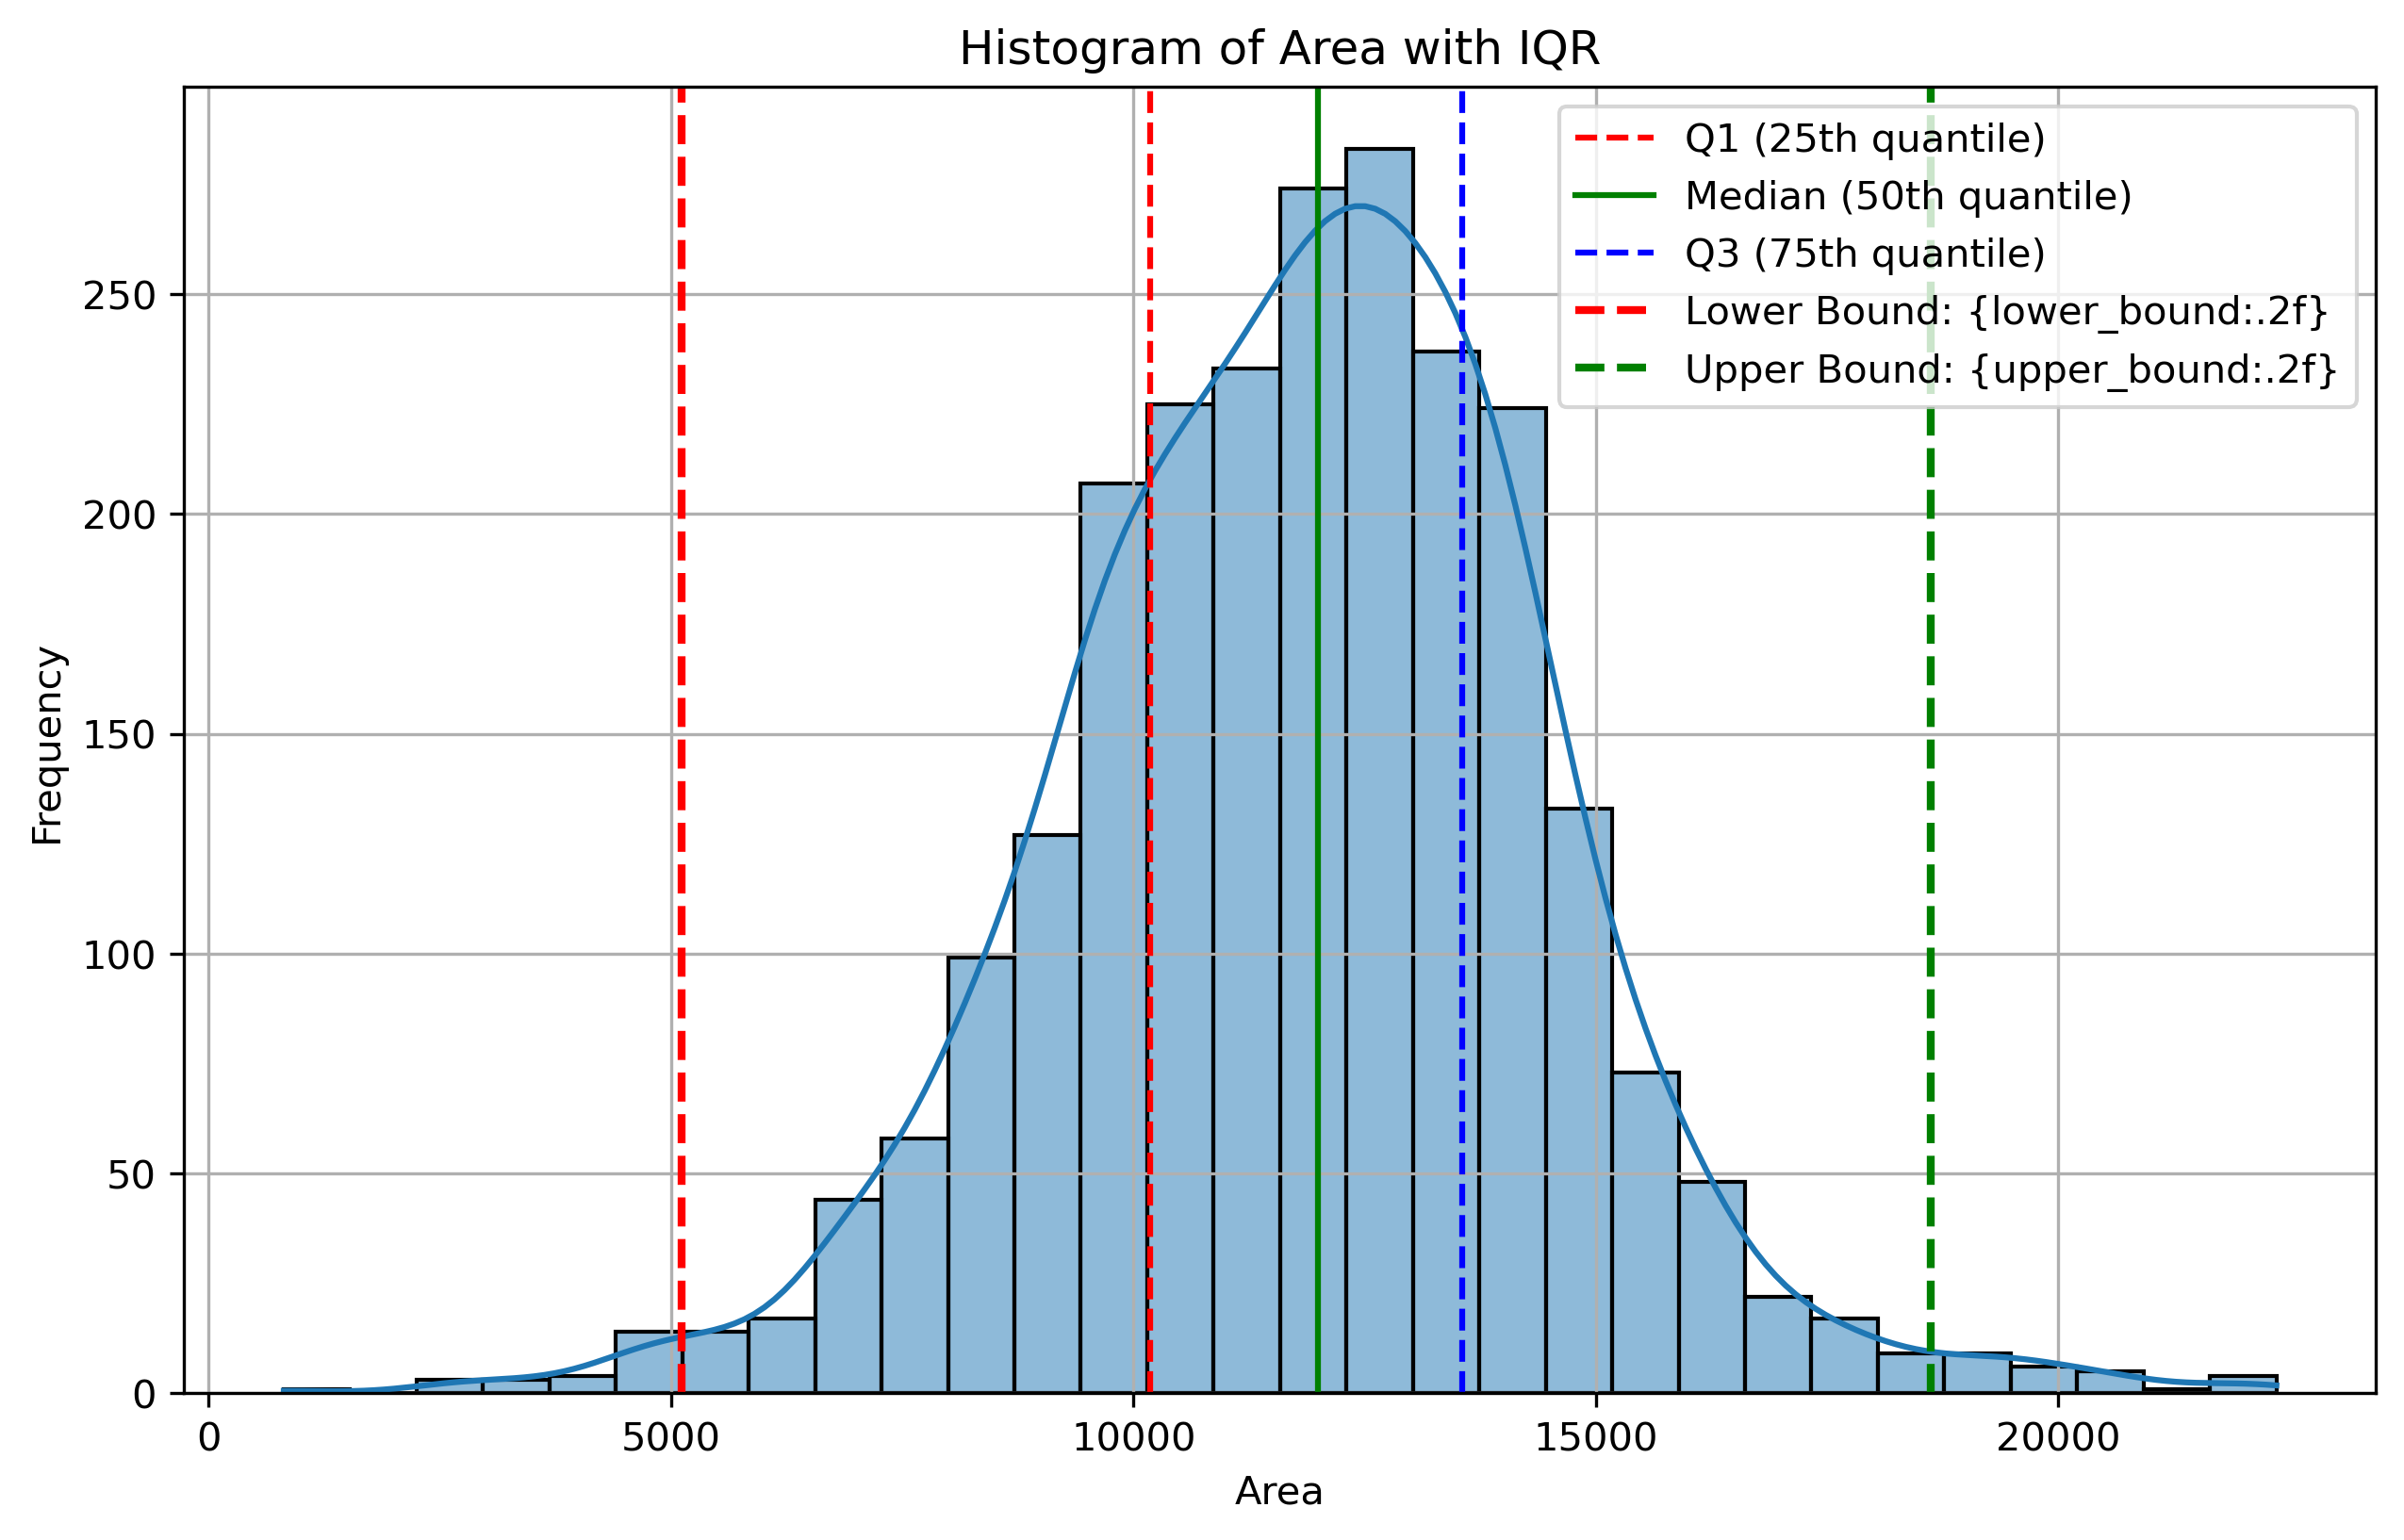

lower_bound =  5113.0
upper_bound =  18625.0


In [19]:
## Defining area (output bounds will be used as cutoffs for outliers in metricPlots.R)
dfResult = combined_data

Q1 = dfResult['area'].quantile(0.25)
Q3 = dfResult['area'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Plotting histogram for the 'area' column in dfResult
plt.figure(figsize=(10, 6))
sns.histplot(dfResult['area'], kde=True, bins=30)
plt.axvline(Q1, color='r', linestyle='--', label='Q1 (25th quantile)')
plt.axvline(dfResult['area'].median(), color='g', linestyle='-', label='Median (50th quantile)')
plt.axvline(Q3, color='b', linestyle='--', label='Q3 (75th quantile)')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f"Lower Bound: {{lower_bound:.2f}}")
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f"Upper Bound: {{upper_bound:.2f}}")
plt.legend()
plt.title('Histogram of Area with IQR')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("lower_bound = ", lower_bound)
print("upper_bound = ", upper_bound)